# Kachowka Dam Break - Rapid Impact Assessment Using Open-source Earth Observation

On June 6, 2023, the Kakhovka Dam in Ukraine broke. We do not yet know who or what was responsible for the collapse of the dam. What we do know, however, are the devastating consequences for the region downstream - especially for the local population.

Using freely-available optical **and** cloud-pentrating synthetic aperature RADAR ([SAR](https://www.earthdata.nasa.gov/learn/backgrounders/what-is-sar)) remote sensing data from [ESA](https://www.esa.int/) and the open-source software [EOdal](https://github.com/EOA-team/eodal), timely monitoring of the flood disaster is possible and allows a precise assessment of the consequences for the local population and agriculture.

This notebook enables users to follow the development at the Kachowka Dam as well as downstream at the [Dnipro or Dnieper](https://en.wikipedia.org/wiki/Dnieper) - for example in the city of Kherson - by means of satellite images lowering the barrier of entry to work with Earth Observation data for disaster relief and emergency response.

## Main Findings

**Evaluation of optical satellite data from ESA already impressively show the extent of the flooding by comparing before and after event images. Due to cloud cover, however, the optical data do not allow a complete near-real-time evaluation. Therefore, we additionally used SAR data penetrating through the clouds. Using simple analysis of the available RADAR data, the area inundated on June 9, 2023, was estimated to be about 25 000 ha (250 km2). Based on the generated water masks, further analysis could be undertaken to estimate the severity of the flood-related damages and associated threads.
With SAR we could roughly estimate the flooded area. However, a more detailed analysis is clearly required. Wit this notebook domain users and experts have the opportunity to do so.**

## Getting Started
First, we need to install EOdal from [pypi](https://pypi.org/project/eodal/).

**Authors: Lukas Valentin Graf & Gregor Perich (2023-06-09/10)**

*Made available under [GPL v3](https://www.gnu.org/licenses/gpl-3.0.en.html)*

In [ ]:
!pip install eodal

##  Part 1: Optical Sentinel-2 Imagery

To start, we use optical Sentinel-2 imagery to get a first rough overview. Optical imagery is it relatively easy and intuitive to interpret but has the severe limitation of clouds, haze and other atmospheric disturbances. We will see below, that cloud cover as actually a limiting factor to assess the entire extent of the current flooding using optical satellite imagery. We use the [Level-2A product](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a) which has been corrected for atmospheric effects and provides bottom-of-atmosphere reflectance values.

### Program logic
We use [EOdal](https://github.com/EOA-team/eodal) to query the [STAC](https://stacspec.org/en/) of, e.g., [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) to fetch the latest [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) scenes covering the [Kachowka dam](https://en.wikipedia.org/wiki/Kakhovka_Dam) and its downstream areas prone to flooding risk after the collapse of the dam on June 6th, 2023. This way, we get an impression about the situation *before* and *after* the deconstruction of the dam, enabling to study the impact of the resulting floodings on local livelihoods and agricultural productivity.

The code below uses the [EOdal](https://github.com/EOA-team/eodal) `Mapper` class to

1. query the available Sentinel-2 imagery between June 1st 2023 and today
2. fetch the Sentinel-2 data and load it for convenient handling into a EOdal `SceneCollection`
3. calculate the Normalized Difference Vegetetation Index ([NDVI](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/)) and Normalized Difference Water Index ([NDWI](https://en.wikipedia.org/wiki/Normalized_difference_water_index)) to asses the extent of flooded areas and the impacts on vegetation and agriculture
4. display the results

In [1]:
# display EOdal version information
import eodal
print(eodal.__version__)

0.2.1


First, we two functions to be used for processing the Sentinel-2 data:

- `mask_clouds` masks out clouds and cloud shadows based on the [Scene Classification Layer](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/processing-levels/level-2) delivered with the atmospherically-corrected Sentinel-2 imagery
- `get_s2_data` executes the actual program logic to load the imagery into this notebook

In [2]:
import geopandas as gpd

from datetime import datetime
from eodal.config import get_settings
from eodal.core.scene import SceneCollection
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs

from pathlib import Path
from typing import List


Settings = get_settings()
# set to True to connect to MS Planetary Computer
Settings.USE_STAC = True


def mask_clouds(ds: Sentinel2) -> Sentinel2:
    """
    Mask clouds and shadows in Sentinel-2 data
    before calculating the NDVI

    :param ds:
        Sentinel-2 dataset
    :return:
        Sentinel-2 dataset with masked clouds and shadows
    """
    # bring scene classification layer to 10 m resolution
    ds.resample(inplace=True, target_resolution=10)
    return ds  #.mask_clouds_and_shadows(cloud_classes=[1, 2, 3, 8, 9, 10, 11])


def get_s2_data(
    mapper: Mapper
) -> SceneCollection:
    """
    Fetch Sentinel-2 scenes

    :param mapper:
        eodal Mapper instance
    """
    mapper.query_scenes()

    # Comment:
    # before reading the scenes, you can check the metadata
    # by calling mapper.metadata to do further filtering

    # load the scenes available from STAC
    # using Sentinel-2 bands B02 (blue), B03 (green), B04 (red) and B08 (nir)
    scene_kwargs = {
        'scene_constructor': Sentinel2.from_safe,
        'scene_constructor_kwargs': {
            'band_selection': ["B02", "B03", "B04", "B08"]},
        'scene_modifier': mask_clouds
        }
    mapper.load_scenes(scene_kwargs=scene_kwargs)
    return mapper.data


## User Inputs

The user inputs below tell [EOdal](https://github.com/EOA-team/eodal) how to query the STAC archive by
- geographic location
- time period
- EO platform and sensor (a.k.a., "collection")
to fetch the latest Sentinel-2 imagery over the Kachowka dam region.

**The inputs below can be used in their current form** or modified according to users' needs, e.g., by modifying the geographic and/or temporal extent.

In [3]:
from shapely.geometry import box

# -------------------------- Paths -------------------------------------
# define the output directory where to save the NDVI GeoTiff files
output_dir = Path('./data')
output_dir.mkdir(exist_ok=True)

# user-inputs
# -------------------------- Collection -------------------------------
collection: str = 'sentinel2-msi'

# ------------------------- Time Range ---------------------------------
time_start: datetime = datetime(2023, 6, 1)  		# year, month, day (incl.)
time_end: datetime = datetime(2023, 6, 9)   		# year, month, day (incl.)

# ----------------------- Cloudy Pixel Percentage ----------------------
cloudy_pixel_percentage: int = 100  # percent (scene-wide)

# ---------------------- Spatial Feature  -----------------------------

geom = Path('kachowka_refined.gpkg')
feature = Feature.from_geoseries(gpd.read_file(geom).geometry)

# ------------------------- Metadata Filters ---------------------------
metadata_filters: List[Filter] = [
    Filter('cloudy_pixel_percentage', '<=', cloudy_pixel_percentage),
    Filter('processing_level', '==', 'Level-2A')]

# setup the EOdal Mapper configurations
mapper_configs = MapperConfigs(
    collection=collection,
    time_start=time_start,
    time_end=time_end,
    feature=feature,
    metadata_filters=metadata_filters)

# now, a new Mapper instance is created
mapper = Mapper(mapper_configs)

### Fetching the metadata

First, we list the scenes available, i.e., the scenes found by querying the [STAC endpoint of Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a) which is supported natively within EOdal.

The metadata is returned as a [geopandas.GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) and is displayed below. Since the area queried is fairly large (100 by 80 km2, approximately), we have to read data from four [Sentinel-2 tiles](https://eatlas.org.au/data/uuid/f7468d15-12be-4e3f-a246-b2882a324f59). This task is handled *automatically* by EOdal.

In [6]:
mapper.query_scenes()
mapper.metadata

product_uri   
8   S2B_MSIL2A_20230603T084559_R107_T36TWT_2023060...  \
9   S2B_MSIL2A_20230603T084559_R107_T36TWS_2023060...   
10  S2B_MSIL2A_20230603T084559_R107_T36TVT_2023060...   
11  S2B_MSIL2A_20230603T084559_R107_T36TVS_2023060...   
4   S2A_MSIL2A_20230605T083601_R064_T36TWT_2023060...   
5   S2A_MSIL2A_20230605T083601_R064_T36TWS_2023060...   
6   S2A_MSIL2A_20230605T083601_R064_T36TVT_2023060...   
7   S2A_MSIL2A_20230605T083601_R064_T36TVS_2023060...   
0   S2A_MSIL2A_20230608T084601_R107_T36TWT_2023060...   
1   S2A_MSIL2A_20230608T084601_R107_T36TWS_2023060...   
2   S2A_MSIL2A_20230608T084601_R107_T36TVT_2023060...   
3   S2A_MSIL2A_20230608T084601_R107_T36TVS_2023060...   

                                             scene_id spacecraft_name tile_id   
8   S2B_OPER_MSI_L2A_TL_MSFT_20230603T131641_A0325...     Sentinel-2B   36TWT  \
9   S2B_OPER_MSI_L2A_TL_MSFT_20230603T131633_A0325...     Sentinel-2B   36TWS   
10  S2B_OPER_MSI_L2A_TL_MSFT_20230603T152835_A0325...     Sentinel-2B   36TVT   
11  S2B_OPER_MSI_L2A_TL_MSFT_20230603T131644_A0325...     Sentinel-2B   36TVS   
4   S2A_OPER_MSI_L2A_TL_MSFT_20230605T142539_A0415...     Sentinel-2A   36TWT   
5   S2A_OPER_MSI_L2A_TL_MSFT_20230605T172508_A0415...     Sentinel-2A   36TWS   
6   S2A_OPER_MSI_L2A_TL_MSFT_20230605T142302_A0415...     Sentinel-2A   36TVT   
7   S2A_OPER_MSI_L2A_TL_MSFT_20230605T142305_A0415...     Sentinel-2A   36TVS   
0   S2A_OPER_MSI_L2A_TL_MSFT_20230608T153328_A0415...     Sentinel-2A   36TWT   
1   S2A_OPER_MSI_L2A_TL_MSFT_20230608T153556_A0415...     Sentinel-2A   36TWS   
2   S2A_OPER_MSI_L2A_TL_MSFT_20230608T153552_A0415...     Sentinel-2A   36TVT   
3   S2A_OPER_MSI_L2A_TL_MSFT_20230608T153331_A0415...     Sentinel-2A   36TVS   

   sensing_date  cloudy_pixel_percentage   epsg            sensing_time   
8    2023-06-03                 2.774573  32636 2023-06-03 08:45:59.024  \
9    2023-06-03                 3.620626  32636 2023-06-03 08:45:59.024   
10   2023-06-03                52.769053  32636 2023-06-03 08:45:59.024   
11   2023-06-03                 8.128048  32636 2023-06-03 08:45:59.024   
4    2023-06-05                 0.164285  32636 2023-06-05 08:36:01.024   
5    2023-06-05                 0.026483  32636 2023-06-05 08:36:01.024   
6    2023-06-05                 0.000000  32636 2023-06-05 08:36:01.024   
7    2023-06-05                 0.019367  32636 2023-06-05 08:36:01.024   
0    2023-06-08                49.093780  32636 2023-06-08 08:46:01.024   
1    2023-06-08                95.363289  32636 2023-06-08 08:46:01.024   
2    2023-06-08                66.949093  32636 2023-06-08 08:46:01.024   
3    2023-06-08                69.144702  32636 2023-06-08 08:46:01.024   

    sun_azimuth_angle  sun_zenith_angle   
8          155.736572         26.714233  \
9          155.074735         25.882101   
10         153.194665         27.097576   
11         152.514307         26.274703   
4          150.612922         27.282335   
5          149.824073         26.484560   
6          148.178951         27.735574   
7          147.382121         26.948230   
0          154.929290         26.268070   
1          154.228862         25.441012   
2          152.367945         26.662801   
3          151.649021         25.845461   

                                                 geom   
8   POLYGON ((34.44203 46.92524, 34.42030 46.87563...  \
9   POLYGON ((34.44200 46.92516, 34.42030 46.87563...   
10  POLYGON ((31.66287 47.84591, 33.13047 47.85363...   
11  POLYGON ((31.68544 46.94616, 33.12827 46.95364...   
4   POLYGON ((32.99974 47.09385, 33.04734 47.22571...   
5   POLYGON ((32.99974 46.95371, 34.44251 46.94462...   
6   POLYGON ((32.91746 46.86454, 32.94180 46.93271...   
7   POLYGON ((32.59963 45.96280, 32.63143 46.05403...   
0   POLYGON ((34.44232 46.93558, 34.43290 46.91409...   
1   POLYGON ((34.44227 46.93546, 34.43290 46.91409...   
2   POLYGON ((31.66287 47.84591, 33.13047 47.85363...   
3   POLYGON ((31.68544 46.

### Loading the data

Once the *available data* has been queried we have to *load it* it into an EOdal `SceneCollection`. A `SceneCollection` is a collection of zero to *N* scenes with a scene being a Sentinel-2 image of a specific date and region of interest.

In [7]:
# fetch the data. This is the actual I/O operation.
mapper_pop = get_s2_data(mapper)

2023-06-10 09:59:10,037 eodal        INFO     Starting extraction of sentinel2 scenes
2023-06-10 10:04:06,905 eodal        INFO     Finished extraction of sentinel2 scenes


When the loading process is finished (it takes some minutes because of the large extent of the area and the need to [mosaic](https://en.wikipedia.org/wiki/Image_stitching) four Sentinel-2 into a single image) the data becomes available as an EOdal `SceneCollection`:

In [8]:
mapper.data

EOdal SceneCollection
----------------------
# Scenes:    3
Timestamps:    2023-06-03 08:45:59, 2023-06-05 08:36:01, 2023-06-08 08:46:01
Scene Identifiers:    S2B_MSIL2A_20230603T084559_N0509_R107_T36TWT_20230603T131640.SAFE&&S2B_MSIL2A_20230603T084559_N0509_R107_T36TWS_20230603T131632.SAFE&&S2B_MSIL2A_20230603T084559_N0509_R107_T36TVT_20230603T152834.SAFE&&S2B_MSIL2A_20230603T084559_N0509_R107_T36TVS_20230603T131643.SAFE, S2A_MSIL2A_20230605T083601_N0509_R064_T36TWT_20230605T142537.SAFE&&S2A_MSIL2A_20230605T083601_N0509_R064_T36TWS_20230605T172507.SAFE&&S2A_MSIL2A_20230605T083601_N0509_R064_T36TVT_20230605T142301.SAFE&&S2A_MSIL2A_20230605T083601_N0509_R064_T36TVS_20230605T142303.SAFE, S2A_MSIL2A_20230608T084601_N0509_R107_T36TWT_20230608T153327.SAFE&&S2A_MSIL2A_20230608T084601_N0509_R107_T36TWS_20230608T153555.SAFE&&S2A_MSIL2A_20230608T084601_N0509_R107_T36TVT_20230608T153551.SAFE&&S2A_MSIL2A_20230608T084601_N0509_R107_T36TVS_20230608T153329.SAFE

### Calculating spectral indices

As a third step, we now calculate two spectral indices: NDVI and NDWI.

- NDVI is sensitive to vegetation greeness, taking values between -1 and +1; the higher values >0 indicate bare soil and green vegetation, whereas values <0 are associated with, e.g., water bodies. **NDVI is widely used to detect green vegetation.**
- NDWI is sensitive to water bodies taking values between -1 and +1. Values >0 indicate the presence of open water surfaces in satellite imagery. **NDWI is used to detect water bodies**.

In [9]:
# calculate spectral indices including the NDVI and NDWI
for _, scene in mapper.data:
    scene.calc_si('NDVI', inplace=True)
    scene.calc_si('NDWI', inplace=True)

To avoid reloading the data again and again, we can save the data as, e.g., GeoTiff files and read it again from there into EOdal:

In [11]:
for timestamp, scene in mapper.data:
    scene.to_rasterio(f's2_{timestamp}.tiff')

### Visualization

We can use EOdal to visualize, e.g., [false-color infrared plots of Sentinel-2 scenes](https://earthobservatory.nasa.gov/features/FalseColor/page6.php). Here, red colors indicate healthy vegetation while water bodies appear in darker colors making a separation between land and water bodies fairly easy. However, we also see that on 2023-06-08 we have also a lot of clouds covering parts of the flooded area.

#### False color infrared

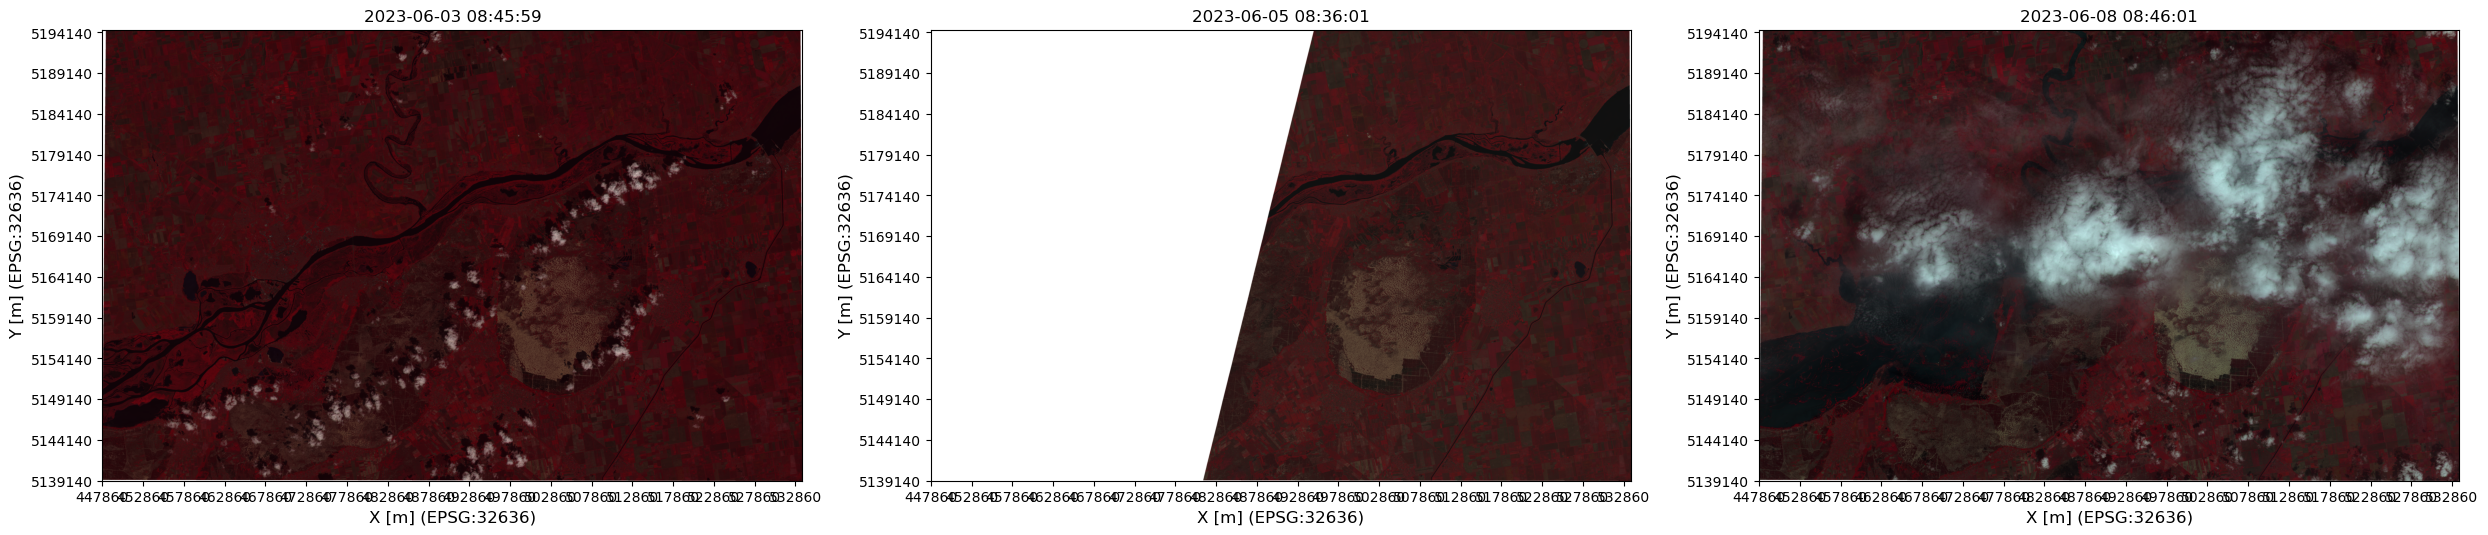

In [12]:
f = mapper_pop.plot(['nir_1', 'red', 'green'], figsize=(25, 25))

In [13]:
f.savefig('s2_rgb_01-09_Jun.png', bbox_inches='tight')

### Normalized Difference Water Index (NDWI)

The NDWI clearly shows the increase in the flooded area from before and after the catastrophic event. However, the clouds on 2023-06-08 hide the underlying flooded areas so we cannot map the extent of the floods in this region.

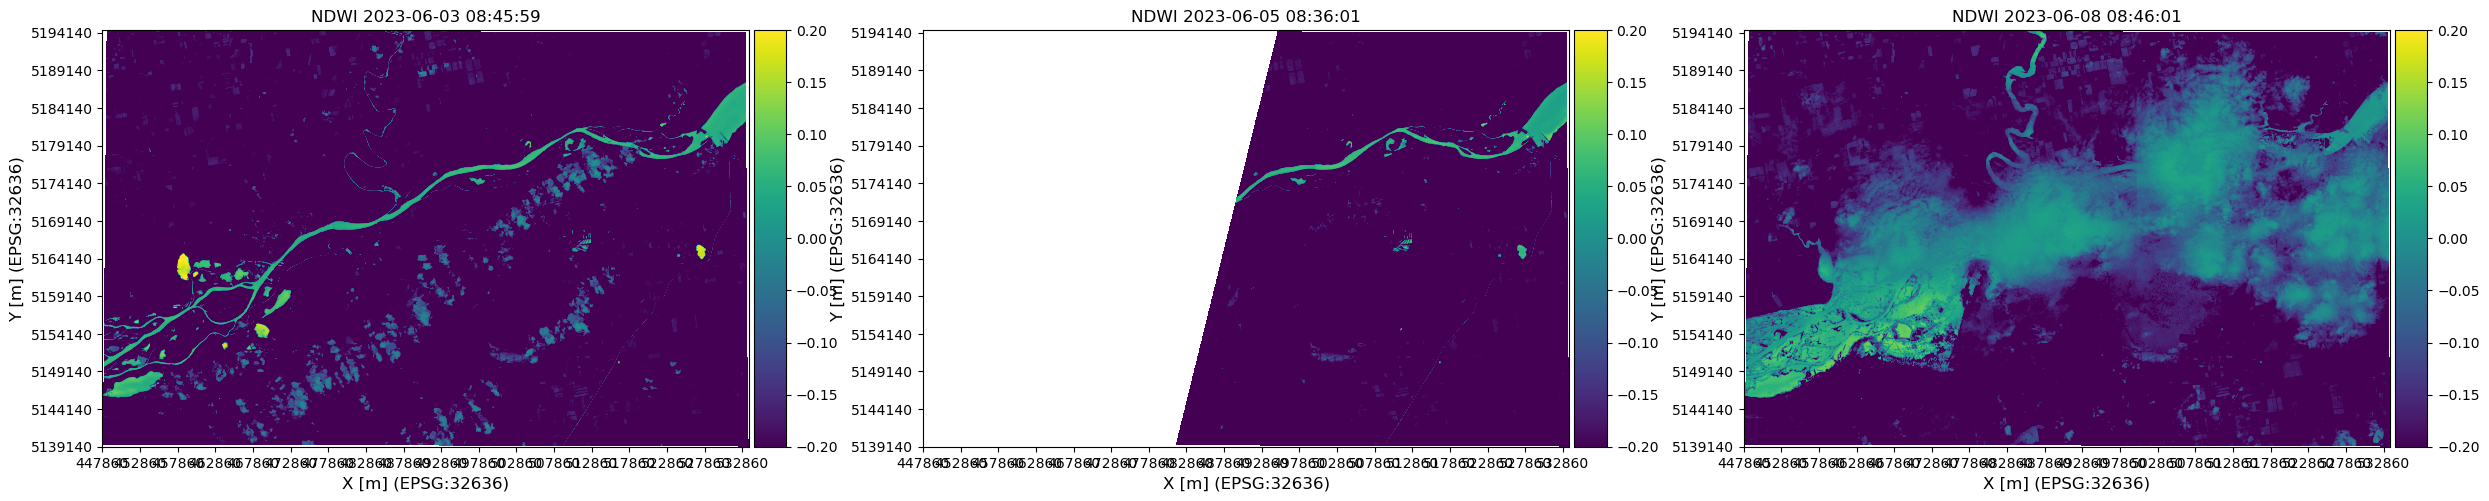

In [14]:
import matplotlib.pyplot as plt

f, ax  = plt.subplots(ncols=len(mapper_pop), figsize=(len(mapper_pop)*10, len(mapper_pop)*10))
idx = 0
for time_stamp, scene in mapper.data:
    scene['ndwi'].plot(vmin=-0.2, vmax=0.2, colormap='viridis', ax=ax[idx])
    ax[idx].set_title(f'NDWI {time_stamp}')
    idx += 1

In [15]:
f.savefig('ndwi.png', bbox_inches='tight')

#### Normalized Difference Vegetation Index (NDVI)

The NDVI shows a picture similar to the NDWI. Again, the clouds cover some crucial areas.

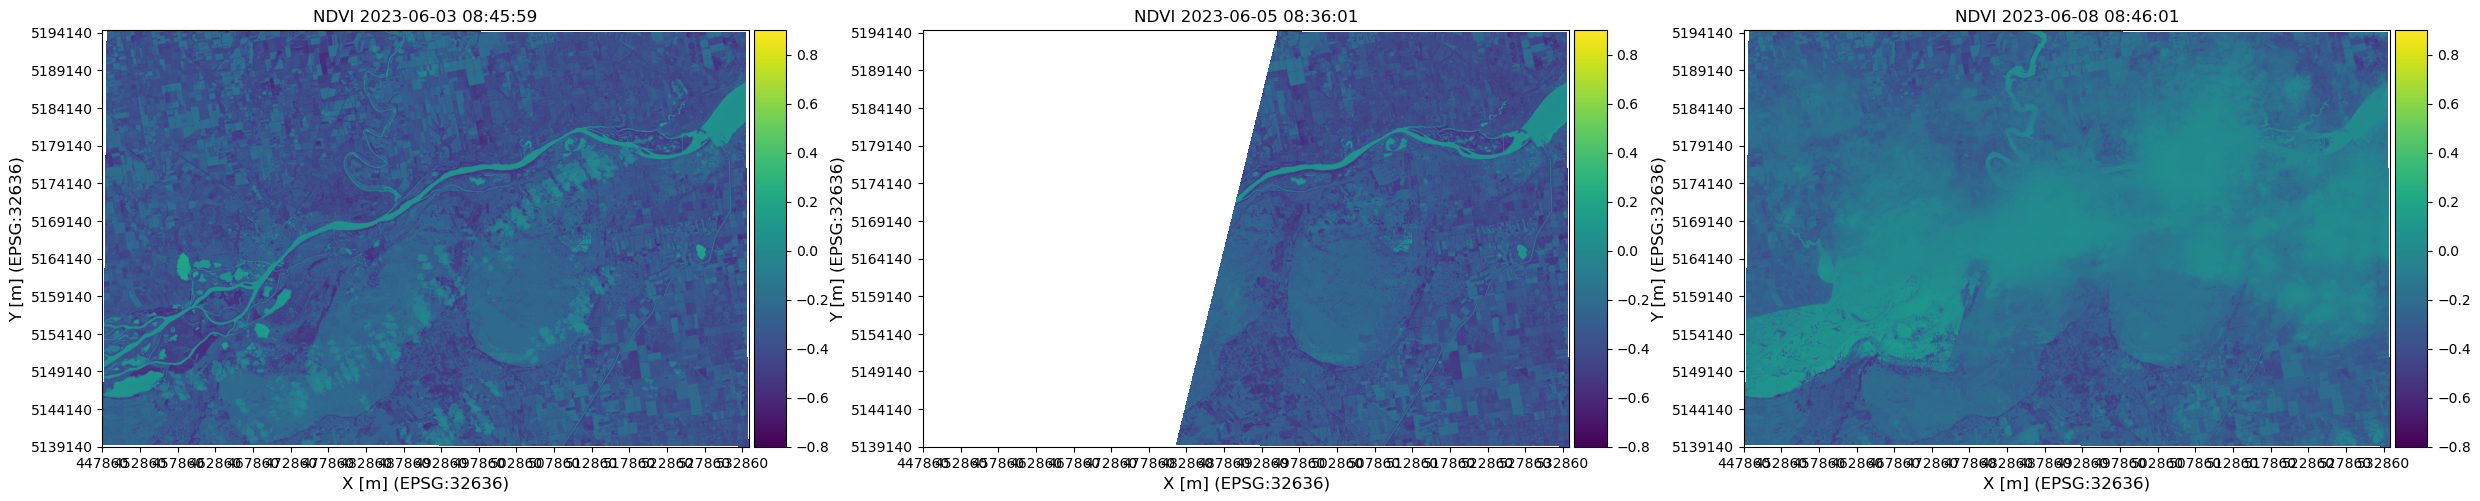

In [16]:
f, ax  = plt.subplots(ncols=len(mapper_pop), figsize=(len(mapper_pop)*10, len(mapper_pop)*10))
idx = 0
for time_stamp, scene in mapper.data:
    scene['ndwi'].plot(vmin=-0.8, vmax=0.9, colormap='viridis', ax=ax[idx])
    ax[idx].set_title(f'NDVI {time_stamp}')
    idx += 1

### Creating a Water Mask using the NDWI

Using a threshold of NDWI > 0.05 we extract a binary water mask from the Sentinel-2 images. These show a clear increase in the water area downstream the broken dam highlighting the massive spatial extent of the floodings. Due to the aforementioned clouds, we actually miss a quiet significant part of the flooding.

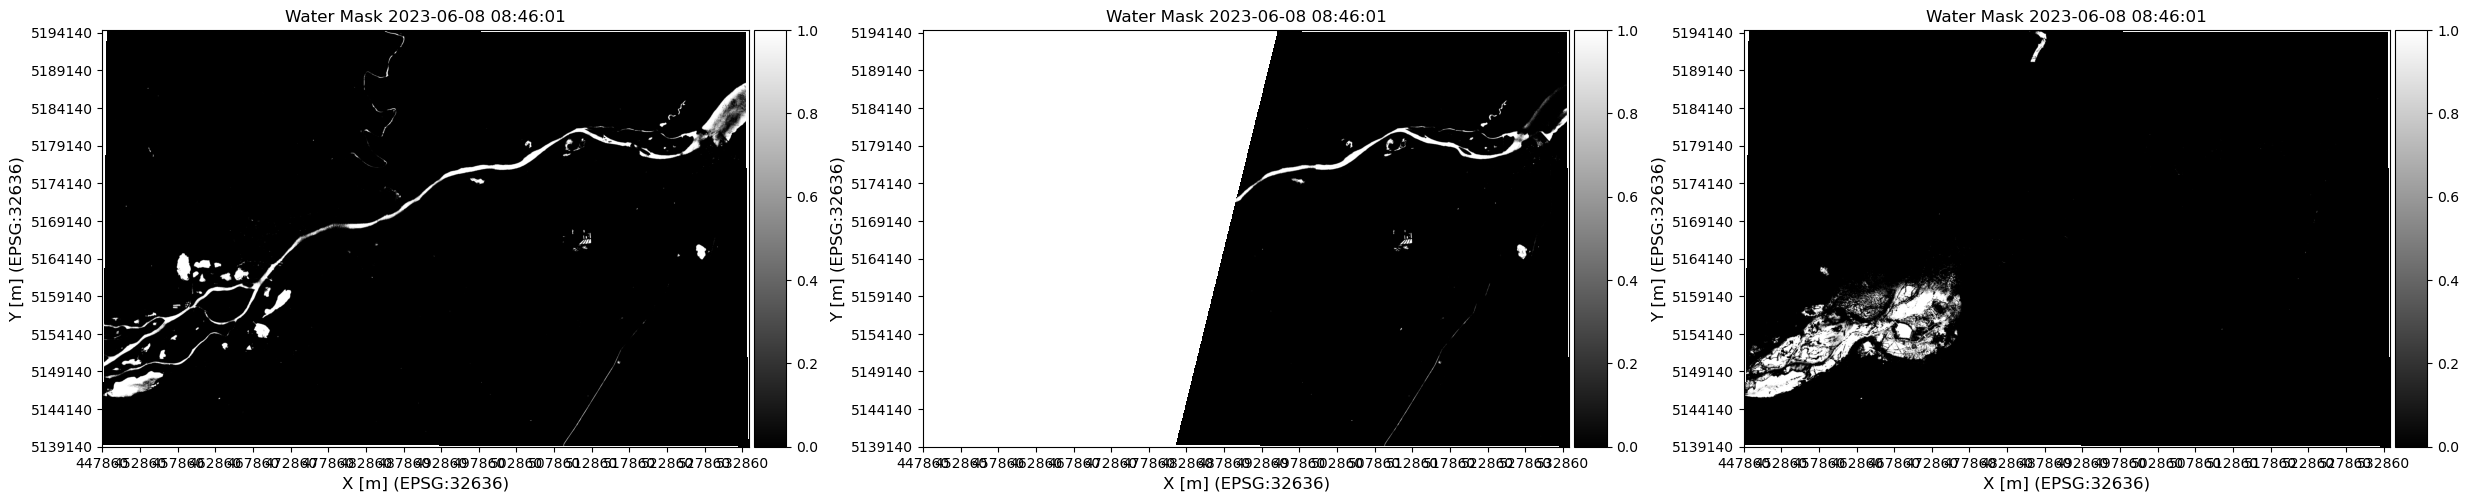

In [17]:
import matplotlib.pyplot as plt

f, ax  = plt.subplots(ncols=len(mapper_pop), figsize=(len(mapper_pop)*10, len(mapper_pop)*10))
idx = 0
for timestamp, scene in mapper.data:
    water_mask = scene['ndwi'] > 0.05
    water_mask.plot(ax=ax[idx], vmin=0, vmax=1)
    ax[idx].set_title(f'Water Mask {time_stamp}')
    idx += 1

In [18]:
f.savefig('water_mask_ndwi.png', bbox_inches='tight')

### Summary Part 1 - Optical Satellite Imagery

If there were no clouds, we could generate a water mask using the NDWI from Sentinel-2 images and calculate the extent of the floodings by comparing the pre- and post event water masks. Unfortunately, we now are exactly in the situation in which optical satellite imagery reaches its limits: The presence of clouds and haze does not allow us (yet) to create a water mask after the dam break.

Simple put, we need another source of data which is insensitive to clouds: [SAR](https://www.earthdata.nasa.gov/learn/backgrounders/what-is-sar).

##  Part 2: SAR Imagery

As discussed above, we will use [SAR](https://www.earthdata.nasa.gov/learn/backgrounders/what-is-sar) data as alternative or complementary data source to estimate the impact of the floodings after the dam break.

We use the [Radiometry-Terrain-Corrected (RTC) product](https://planetarycomputer.microsoft.com/docs/tutorials/customizable-rtc-sentinel1/) compromising SAR data corrected for geometric and terrain distortions. The RTC product contains back-scatter intensity values acquired in VV and VH polarization mode.

### Program logic
As for Sentinel-2 optical imagery use [EOdal](https://github.com/EOA-team/eodal) to query the [STAC](https://stacspec.org/en/) of [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) to fetch the latest [Sentinel-1](https://sentinel.esa.int/web/sentinel/missions/sentinel-1) scenes covering the [Kachowka dam](https://en.wikipedia.org/wiki/Kakhovka_Dam) and its downstream areas prone to flooding risk after the collapse of the dam on June 6th, 2023. This way, we get an impression about the situation *before* and *after* the deconstruction of the dam, enabling to study the impact of the resulting floodings on local livelihoods and agricultural productivity.

The code below uses the [EOdal](https://github.com/EOA-team/eodal) `Mapper` class to

1. query the available Sentinel-1 SAR imagery between June 1st 2023 and today
2. fetch the Sentinel-1 data and load it for convenient handling into a EOdal `SceneCollection`
3. display the results

**NOTE**: Thanks to the design of EOdal little has to be changed when working with another sensor or platform.

In [19]:
# we make a new Mapper call similar to the one we made when fetching the Sentinel-2 data
# the geographic location and time period stay the same as for Sentinel-2
collection = 'sentinel1-grd'
metadata_filters = [Filter('product_type','==', 'RTC')]

mapper_configs = MapperConfigs(
    collection=collection,
    time_start=time_start,
    time_end=time_end,
    feature=feature,
    metadata_filters=metadata_filters
)
mapper = Mapper(mapper_configs)
mapper.query_scenes()

mapper.metadata

platform        s1:shape                                   proj:bbox   
5  SENTINEL-1A  [28432, 20967]  [395400.0, 5155680.0, 679720.0, 5365350.0]  \
4  SENTINEL-1A  [28501, 21067]  [366260.0, 4988610.0, 651270.0, 5199280.0]   
3  SENTINEL-1A  [28375, 20775]  [266880.0, 5072560.0, 550630.0, 5280310.0]   
2  SENTINEL-1A  [28737, 21542]  [244550.0, 5184570.0, 531920.0, 5399990.0]   
1  SENTINEL-1A  [28775, 21638]  [211420.0, 5018250.0, 499170.0, 5234630.0]   
0  SENTINEL-1A  [28671, 21356]  [420380.0, 5081650.0, 707090.0, 5295210.0]   

   proj:epsg      proj:shape                      end_datetime constellation   
5      32636  [20967, 28432]  2023-06-01 03:56:58.526216+00:00    Sentinel-1  \
4      32636  [21067, 28501]  2023-06-01 03:57:23.525328+00:00    Sentinel-1   
3      32636  [20775, 28375]  2023-06-02 15:45:34.107401+00:00    Sentinel-1   
2      32636  [21542, 28737]  2023-06-06 04:05:07.651342+00:00    Sentinel-1   
1      32636  [21638, 28775]  2023-06-06 04:05:32.651730+00:00    Sentinel-1   
0      32636  [21356, 28671]  2023-06-09 15:37:22.350480+00:00    Sentinel-1   

  s1:resolution                                     proj:transform   
5          high  [10.0, 0.0, 395400.0, 0.0, -10.0, 5365350.0, 0...  \
4          high  [10.0, 0.0, 366260.0, 0.0, -10.0, 5199280.0, 0...   
3          high  [10.0, 0.0, 266880.0, 0.0, -10.0, 5280310.0, 0...   
2          high  [10.0, 0.0, 244550.0, 0.0, -10.0, 5399990.0, 0...   
1          high  [10.0, 0.0, 211420.0, 0.0, -10.0, 5234630.0, 0...   
0          high  [10.0, 0.0, 420380.0, 0.0, -10.0, 5295210.0, 0...   

  s1:datatake_id  ... sar:observation_direction sar:pixel_spacing_azimuth   
5         384506  ...                     right                        10  \
4         384506  ...                     right                        10   
3         384673  ...                     right                        10   
2         385081  ...                     right                        10   
1         385081  ...                     right                        10   
0         385466  ...                     right                        10   

  sar:looks_equivalent_number s1:instrument_configuration_ID   
5                         4.4                              7  \
4                         4.4                              7   
3                         4.4                              7   
2                         4.4                              7   
1                         4.4                              7   
0                         4.4                              7   

   sat:platform_international_designator   
5                              2014-016A  \
4                              2014-016A   
3                              2014-016A   
2                              2014-016A   
1                              2014-016A   
0                              2014-016A   

                                              assets   
5  {'vh': {'href': 'https://sentinel1euwestrtc.bl...  \
4  {'vh': {'href': 'https://sentinel1euwestrtc.bl...   
3  {'vh': {'href': 'https://sentinel1euwestrtc.bl...   
2  {'vh': {'href': 'https://sentinel1euwestrtc.bl...   
1  {'vh': {'href': 'https://sentinel1euwestrtc.bl...   
0  {'vh': {'href': 'https://sentinel1euwestrtc.bl...   

                  sensing_time  sensing_date   epsg   
5  2023-06-01T03:56:46.026654Z    2023-06-01  32636  \
4  2023-06-01T03:57:11.026515Z    2023-06-01  32636   
3  2023-06-02T15:45:21.608693Z    2023-06-02  32636   
2  2023-06-06T04:04:55.151897Z    2023-06-06  32636   
1  2023-06-06T04:05:20.152285Z    2023-06-06  32636   
0  2023-06-09T15:37:09.851429Z    2023-06-09  32636   

                                                geom  
5  POLYGON ((35.34395 46.54589, 35.34395 48.43269...  
4  POLYGON ((34.91302 45.04790, 34.91302 46.93445...  
3  POLYGON ((33.61186 45.78482, 33.61186 47.67153...  
2  POLYGON ((33.37061 46.82195, 33.37061 48.70880...  
1  POLYGON ((32.93622 45.32330, 32.93622 47.21066...  


In the exact some way as we did with the Sentinel-2 data, we can now also fetch the Sentinel-1 scenes:

In [21]:
from eodal.core.sensors import Sentinel1

scene_kwargs = {
    'scene_constructor': Sentinel1.from_safe,
    'scene_constructor_kwargs': {}
}
mapper.load_scenes(scene_kwargs=scene_kwargs)
mapper

2023-06-10 10:24:38,443 eodal        INFO     Starting extraction of sentinel1 scenes
2023-06-10 10:27:01,008 eodal        INFO     Finished extraction of sentinel1 scenes


EOdal Mapper
EOdal MapperConfig
------------------
Collection: sentinel1-grd
Time Range: 2023-06-01 00:00:00 - 2023-06-10 09:58:55.923553
Feature:
Name		geometry
Geometry	POLYGON ((32.321750162144454 46.405059616297436, 32.321750162144454 46.901811568162245, 33.43877794695277 46.901811568162245, 33.43877794695277 46.405059616297436, 32.321750162144454 46.405059616297436))
EPSG Code	4326
Attributes	{}
Metadata Filters: [product_type == RTC]
Data Source: STAC (https://planetarycomputer.microsoft.com/api/stac/v1)

### Plot the available SAR scenes

We plot the available SAR scenes, using the backscatter in VH polarization. If you are unfamiliar with SAR have a look [here](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/overview) to learn more and familiarize yourself with the basic terminologies.

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


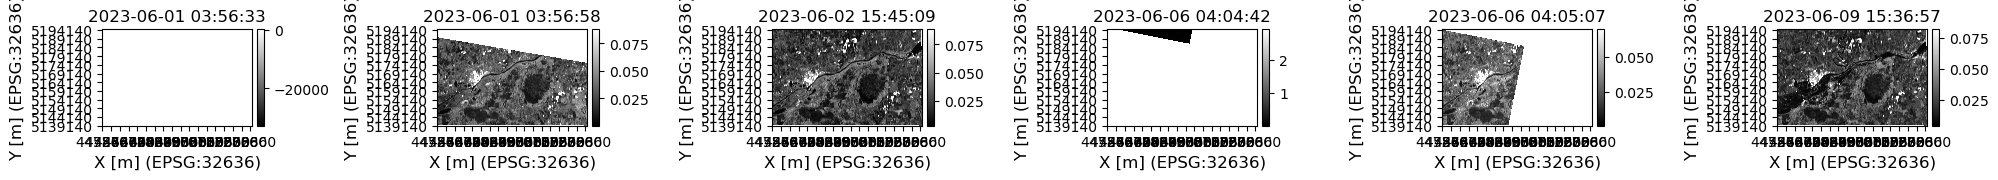

In [22]:
f = mapper.data.plot(band_selection=['VH'], figsize=(20,20))

We nicely see a clear difference between the pre-event situation depicted on the scene acquired on 2023-06-02 15:15:09, and after the event on 2023-06-09 15:36:57.
Thus, we will plot these scenes side-by-side to get an impression about the extent of the floods. In sharp contrast to the optical data, the SAR data is not perturbed by clouds.

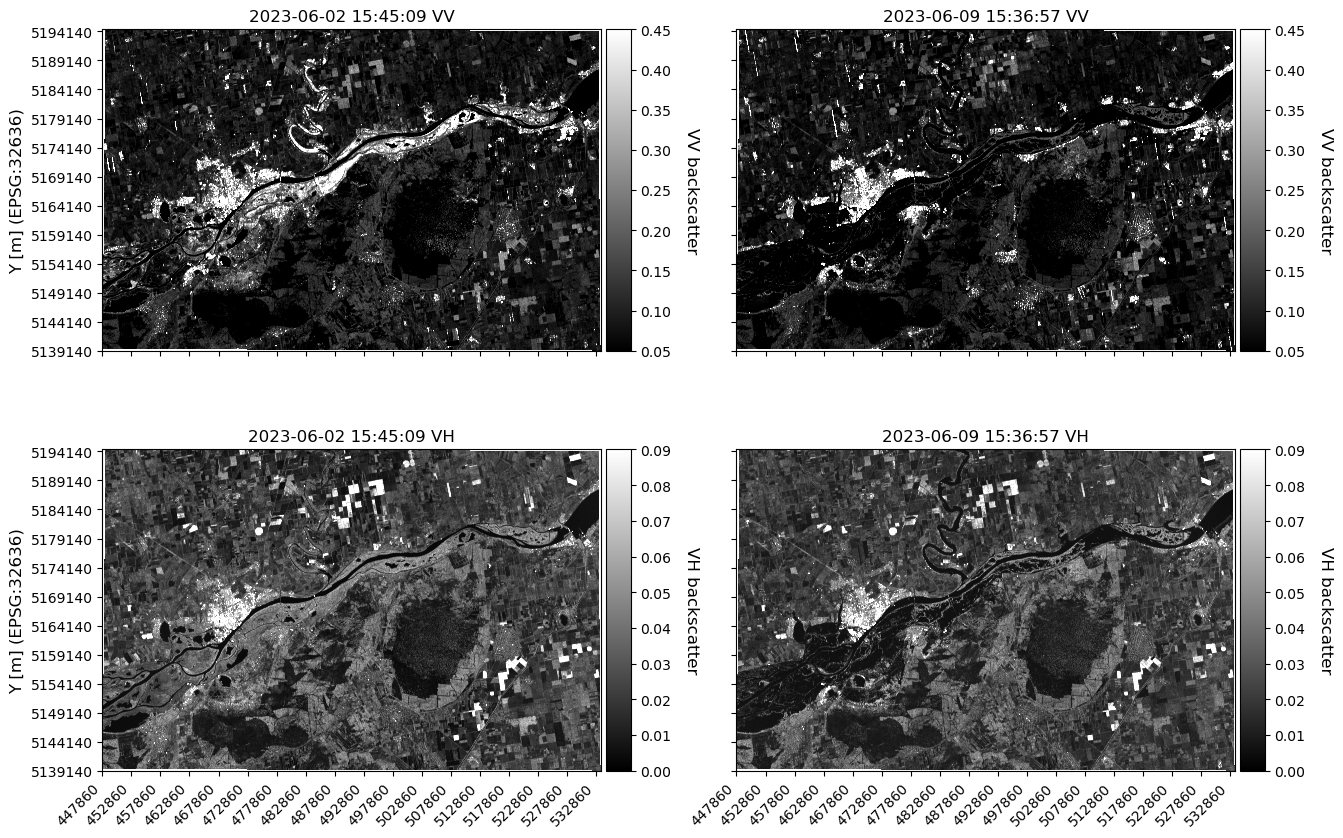

In [24]:
# plot pre- and post-dam break
selected_times = ['2023-06-02 15:45:09', '2023-06-09 15:36:57']
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharey=True, sharex=True)
idx = 0
for timestamp, scene in mapper.data:
    if str(timestamp) in selected_times:
        scene['VV'].plot(ax=ax[0, idx], colorbar_label='VV backscatter', vmin=0.05, vmax=0.45)
        ax[0, idx].set_title(f'{timestamp} VV')
        ax[0, idx].set_xlabel('')
        scene['VH'].plot(ax=ax[1, idx], colorbar_label='VH backscatter', vmin=0., vmax=0.09)
        ax[1, idx].set_title(f'{timestamp} VH')
        ax[1, idx].set_xlabel('')
        ax[1, idx].set_xticks(ax[1, idx].get_xticks(), ax[1, idx].get_xticklabels(), rotation=45, ha='right')

        if idx == 1:
            for jdx in range(2):
                ax[jdx, idx].set_ylabel('')
        idx += 1

In [25]:
f.savefig('s1_pre-post_dam_break.png')

In both polarizations, VV (top) and VH (bottom) we see a clear difference between the pre- (left) and post-event (right) conditions. The full extent of the flooding downstream the dam are now clearly visible.

### Creating a simple water mask

We can threshold, for instance, the VH polarization before and after the dam break to get a (very rough) water mask. The water mask actually also covers *some* areas which are actually not water (but, for instance, sand dunes). Still, these misassignments will be largely the same in both scenes, so the change in the masks will be most likely caused by the flooding giving an estimate about how much area was impacted.

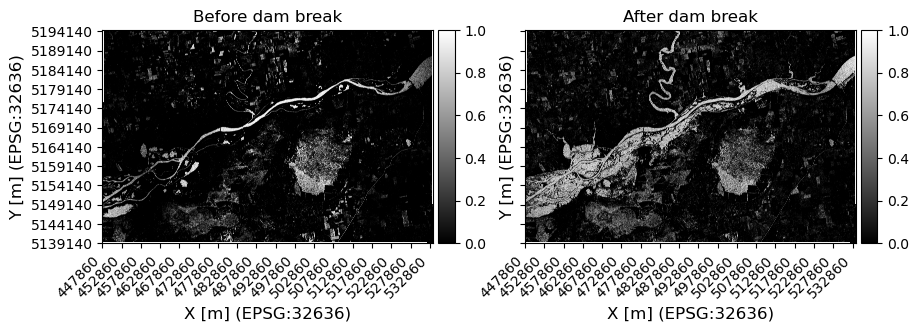

In [40]:
# water mask calculation
f, ax = plt.subplots(ncols=2, figsize=(10,8), sharex=True, sharey=True)
idx = 0
masks = []
thresholds = [0.0045, 0.007]
for timestamp, scene in mapper.data:
    if str(timestamp) in selected_times:
        mask = scene['VH'] < thresholds[idx]
        mask.plot(ax=ax[idx], vmin=0, vmax=1)
        ax[idx].set_xticks(ax[idx].get_xticks(), ax[idx].get_xticklabels(), rotation=45, ha='right')
        if idx == 0:
            ax[idx].set_title('Before dam break')
        else:
            ax[idx].set_title('After dam break')
        idx += 1
        masks.append(mask)
    # save the two selected scenes as GeoTiff files similar to the Sentinel-2 data
    # scene.to_rasterio(f's1_{timestamp}.tiff')

### Get the flooded area extent

In [41]:
import numpy as np

water_pixels_before = np.unique(masks[0].values.data, return_counts=True)[1][1]
water_pixels_after = np.unique(masks[1].values.data, return_counts=True)[1][1]

# multiply by the size of a pixel
pixel_size_x, pixel_size_y = masks[0].geo_info.pixres_x, masks[0].geo_info.pixres_y
pixel_area = abs(pixel_size_x * pixel_size_y)

water_area_before = pixel_area * water_pixels_before * 0.0001  # square meters -> hectares
water_area_after = pixel_area * water_pixels_after * 0.0001

print(
    f'Water area before dam break: {np.round(water_area_before, 0)} ha\n' +
    f'Water area after dam break: {np.round(water_area_after, 0)} ha\n' +
    f'The area flooded is thus around {np.round(water_area_after - water_area_before, 0)} ha')

Water area before dam break: 30016.0 ha
Water area after dam break: 54356.0 ha
The area flooded is thus around 24340.0 ha.


Thus, the extent of the flooded area is roughly 25 000 hectares which is around 250 km2. Using the water masks generated from Sentinel-1 further analysis could be carried out to assess the impacts on local livelihoods and agriculture, for instance.

### Summary Part 2 - SAR Satellite Imagery

SAR is valuable data source thanks to its cloud penetrating capacities. The handling of the data in EOdal is as easy as for the optical data but the interpretation clearly requires dedicated skills and knowledge.


## Summary
With SAR we could roughly estimate the flooded area. However, a more detailed analysis is clearly required. Wit this notebook domain users and experts have the opportunity to do so.